# Test to see if scores of tiles fall within 95% credible intervals of scores based on random samples from the population of crowns.



In [1]:
from pathlib import Path
import json

import arviz as az
import pymc as pm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

We want to see if the model scores are dependent on geography. We will test to see if the scores of the tiles (created in `src/mortality_classification_geographic_holdouts.ipynb` and stored as `src/tile_scores.csv`) come from the distribution of scores of random samples of crowns taken from the pooled dataset of all labeled crowns.

The observations that were produced at the end of `src/mortality_classification.ipynb` were created by making a dataframe of all of the labeled crowns from all tiles, then drawing 131,072 random sample populations with 512 crowns in each population.  Model predictions were made and scored for each sample population.  The scores were then saved (`src/obs.csv`).  We will use the accuracy score (since it is available for all tiles) from that file here.

In [2]:
# paths
score_path = Path.cwd() / 'tile_scores.csv'
obs_path = Path.cwd() / 'obs.csv'
img_dir = Path('/home/michael/thesis/images')

# get the tile scores
df = pd.read_csv(score_path)
df

,Unnamed: 0,tile,year,ROC UAC,Accuracy,Log Loss
0,0,10TEL0509245547,2022,1.00000,1.000000,0.026527
1,1,10TDL0458245240,2022,1.00000,1.000000,0.010503
2,2,10TEK0503244655,2022,1.00000,0.998201,0.052565
3,3,10TDL0464245187,2022,1.00000,0.999433,0.010756
4,4,10TDL0480045075,2020,1.00000,1.000000,0.001982
5,5,10TDL0480045075,2022,1.00000,0.999571,0.005549
6,6,10TDL0480045075,2018,NaN,1.000000,NaN
7,7,10TEK0500244992,2022,1.00000,1.000000,0.003267
8,8,10TDL0488245360,2022,0.99904,0.985897,0.145979


In [3]:
#get the column names we will need
cols = df.columns.to_list()[-3:]
cols

['ROC UAC', 'Accuracy', 'Log Loss']

In [4]:
# read scores/observations
obs = pd.read_csv(obs_path)
obs = obs [['roc', 'acc', 'loss']]

# change column names
obs.columns = cols
obs.head()


,ROC UAC,Accuracy,Log Loss
0,0.999959,0.998047,0.019129
1,0.999271,0.998047,0.021949
2,1.000000,1.000000,0.008913
3,1.000000,0.998047,0.011567
4,0.999918,0.996094,0.018860


Define a Bayesian model (using accuracy score) to test how probable it is for the score of a tile to be from the distribution underlying the scores of random populations.  We will define  weakly informative priors for mu and sigma.  We will sample from the scores of the sample populations to estimate the likelihood.  Finally samples will be drawn from the posterior predictive distribution and the 95% highest density interval (HDI) will be found.

In [5]:
def post_likelihoods(observations, score):
    '''returns posterior predictive likelihood for each tile prediction 
    being from the underlying model of the other tiles.'''
    
    # get relevant obs
    obs = observations[score].values

    # Bayesian model
    with pm.Model() as model:
        
        # weakly informative priors
        mu = pm.TruncatedNormal(
            'mu',
            mu=0.9, 
            sigma=0.1, 
            lower=0, 
            upper=1)
        
        sigma = pm.Normal(
            'sigma',
            mu=0.3,
            sigma=0.05
        )
        
        # normal likelihood, with bounds
        observed = pm.TruncatedNormal(
            'observed',
            mu=mu,
            sigma=sigma,
            lower=0,
            upper=1,
            observed=obs
            )
        
        # posterior
        trace = pm.sample(500, tune=2000, cores=16)

    # prior and posterior predictive distribution
    with model:
        prior_predictive = pm.sample_prior_predictive(samples=50)
        posterior_predictive = pm.sample_posterior_predictive(trace)

    return prior_predictive, posterior_predictive, trace


In [6]:
score = 'Accuracy'

# get predictive distributions
prior_predictive, posterior_predictive, trace = post_likelihoods(obs, score)
#draw samples
draws = posterior_predictive['posterior_predictive'].observed.to_numpy().flatten()

# get 95% credible interval
hdi95 = az.hdi(draws, 0.95)
lower = hdi95[0]
upper = hdi95[1]

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [mu, sigma]


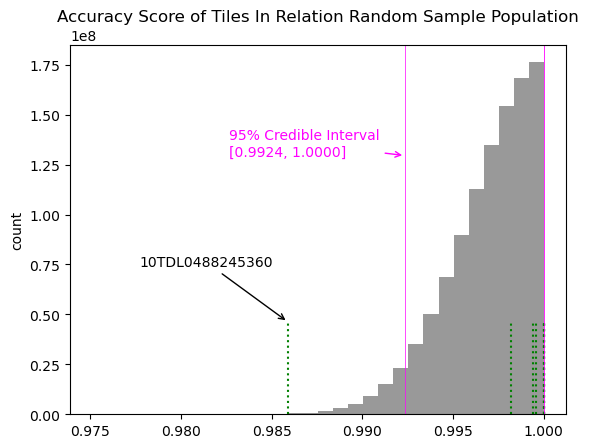

In [ ]:
fig, ax = plt.subplots(1, 1)
ax.hist(
    draws,
    bins=30,
    edgecolor=None,
    facecolor='grey',
    alpha=0.8);

for i, row in df.iterrows():
    ax.axvline(
        row.Accuracy,
        c='g',
        ymax = 0.25,
        linestyle = ":");

t = df[df.Accuracy == df.Accuracy.min()].tile.values[0]
x = df[df.tile == t].Accuracy.values[0]

ax.annotate(t,
            xy=(x, 0.25),
            xycoords=('data', 'axes fraction'),
            xytext=(0.14, 0.4),
            textcoords='axes fraction',
            arrowprops=dict(arrowstyle="->",)
            );

ax.annotate(f'95% Credible Interval\n[{lower:.4f}, {upper:.4f}]',
            xy=(lower, 0.7),
            xycoords=('data', 'axes fraction'),
            xytext=(0.32, 0.7),
            textcoords='axes fraction',
            arrowprops=dict(arrowstyle='->', color='magenta'),
            c='magenta'
            );

ax.set_title('Accuracy Score of Tiles In Relation Random Sample Population');
ax.grid(visible=False)
ax.set_ylabel('count');
ax.axvline(x=lower, c='magenta', **{'linewidth': 0.5});
ax.axvline(x=upper, c='magenta', **{'linewidth': 0.6});

plt.savefig(img_dir / 'accuracy_hdi.png')

/home/michael/miniconda3/envs/pymc_env/lib/python3.11/site-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


array([[<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>],
       [<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'mu'}>]],
      dtype=object)

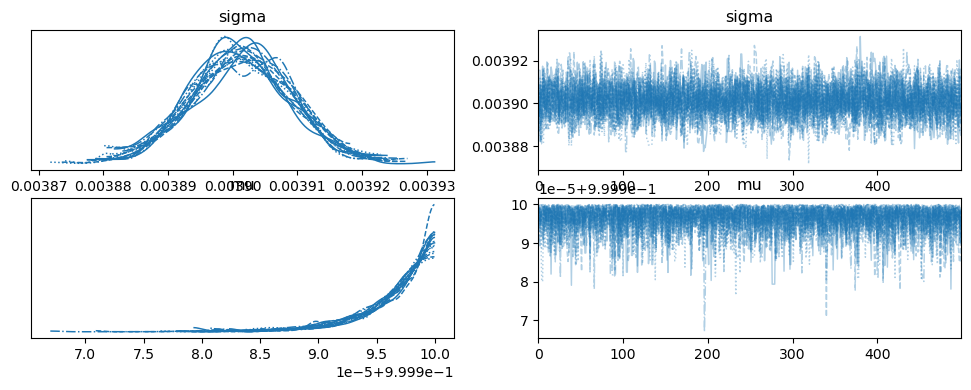

In [ ]:
az.plot_trace(trace.posterior)

In [ ]:
df

,Unnamed: 0,tile,year,ROC UAC,Accuracy,Log Loss
0,0,10TEL0509245547,2022,1.00000,1.000000,0.026527
1,1,10TDL0458245240,2022,1.00000,1.000000,0.010503
2,2,10TEK0503244655,2022,1.00000,0.998201,0.052565
3,3,10TDL0464245187,2022,1.00000,0.999433,0.010756
4,4,10TDL0480045075,2020,1.00000,1.000000,0.001982
5,5,10TDL0480045075,2022,1.00000,0.999571,0.005549
6,6,10TDL0480045075,2018,NaN,1.000000,NaN
7,7,10TEK0500244992,2022,1.00000,1.000000,0.003267
8,8,10TDL0488245360,2022,0.99904,0.985897,0.145979


In [ ]:
t = df[df.Accuracy == df.Accuracy.min()].tile.values[0]
x = df[df.tile == t].Accuracy.values[0]

c = 0.95
while x < lower:
    c = c + 0.01
    hdi = az.hdi(draws, c)
    print(c, hdi[0])
    lower = hdi[0]

while x > lower:
    c = c - 0.001
    hdi = az.hdi(draws, c)
    print(c, hdi[0])
    lower = hdi[0]
